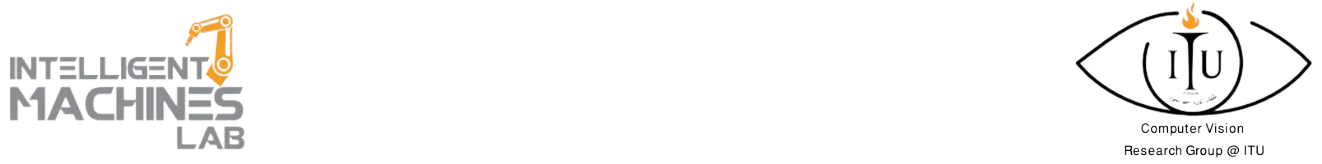

# Assignment 3: Implementing GPT

In this assignment, you will be implementing a GPT-style decoder. A GPT decoder consists of several key components that work together to process input sequences and generate output. Below is a breakdown of each component, including its purpose and significance.

## Components of a GPT Decoder

- **Tokenizer**
  - **Purpose:** Converts raw text into a sequence of tokens (numbers) that can be processed by the model.
  - **Significance:** Allows the model to work with numerical representations of characters or subwords, facilitating efficient computation and training.

- **Token Embedding**
  - **Purpose:** Maps each token to a high-dimensional vector representation.
  - **Significance:** Provides a dense representation of tokens, capturing semantic information that enables the model to understand relationships between tokens.

- **Positional Embedding**
  - **Purpose:** Adds information about the position of each token in the sequence.
  - **Significance:** Since transformers do not inherently understand the order of tokens, positional embeddings allow the model to consider the sequence order, which is crucial for language understanding.

- **Self-Attention Mechanism**
  - **Purpose:** Allows the model to weigh the relevance of different tokens in the sequence when generating a representation for each token.
  - **Significance:** Enables the model to capture contextual relationships and dependencies between tokens, enhancing its ability to understand the meaning of phrases and sentences.

- **Multi-Head Attention**
  - **Purpose:** Extends the self-attention mechanism by using multiple attention heads to focus on different parts of the sequence simultaneously.
  - **Significance:** Captures diverse contextual information, improving the model’s ability to understand complex patterns in the data.

- **Layer Normalization**
  - **Purpose:** Normalizes the inputs to each layer to improve convergence and stability during training.
  - **Significance:** Helps in mitigating issues like vanishing gradients and accelerates the training process by ensuring consistent scaling of inputs across layers.

- **Feed-Forward Network**
  - **Purpose:** Applies a series of linear transformations and non-linear activations to the output of the attention layers.
  - **Significance:** Introduces non-linearity and enables the model to learn complex functions, enhancing its expressiveness and ability to model intricate relationships in the data.

### Implementation Notes
As you implement each component, ensure that they interact correctly to form a cohesive decoder. Test each part individually and verify that they produce the expected outputs. Your final decoder should be able to process input sequences and generate coherent text.

Remember to refer to the GPT architecture when structuring your implementation and consider how each component contributes to the overall functionality of the decoder.

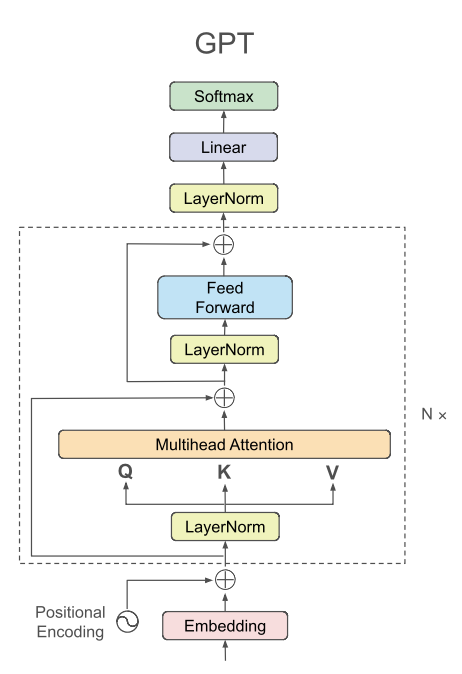

In [47]:
import torch

import torch.nn as nn
import torch.nn.functional as F

## Building a Character Tokenizer

We first start with the tokenizer. The tokenizer is used to convert the input text to bunch of numbers on which we can do computation

You will implement a simple character-based tokenizer. The goal is to identify all unique characters in the dataset and map each character to a unique number. The tokenizer will map each character in the input text to a unique integer (encoding) and back from integers to characters (decoding).

### Encoder
The encoder will map each character in the input text to a unique number.

### Decoder
The decoder will map each number back to its corresponding character, reversing the encoding process.

### Example

**Input Text:** `What's up`

**Encoded List:** `[35, 46, 39, 58, 5, 57, 1, 59, 54, 12]`

**Decoded List:** `"What's up?"`


In [48]:
text = open("input.txt", "r").read()

chars = sorted(list(set(text)))

vocab_size = len(chars)

encoder = {ch: i for i, ch in enumerate(chars)}
decoder = {i: ch for i, ch in enumerate(chars)}


def encode(s):
    return [encoder[c] for c in s]


def decode(s):
    return "".join([decoder[i] for i in s])


if len(encoder) != 65 or len(decoder) != 65:
    raise ValueError(
        "Recheck your encoder and decoder. There should be 65 unique mappings."
    )

print(list(encoder.items())[:5])
print(list(decoder.items())[:5])

[('\n', 0), (' ', 1), ('!', 2), ('$', 3), ('&', 4)]
[(0, '\n'), (1, ' '), (2, '!'), (3, '$'), (4, '&')]


In [49]:
torch.manual_seed(1337)

batch_size = 16  # Number of independent sequences processed in parallel during training.
block_size = 32  # Maximum length of the context (input sequence length) for making predictions.
max_iter = 2400  # Total number of training iterations.
eval_interval = 100  # Evaluate the model every 'eval_interval' iterations.
learning_rate = 1e-3  # Step size for the optimizer during backpropagation (controls speed of learning).
device = "cuda" if torch.cuda.is_available() else 'cpu'  # Use Apple Silicon GPU if available, otherwise CPU.
eval_iters = 200  # Number of iterations to perform during evaluation.
n_embd = 64  # Dimensionality of the embeddings (size of the embedding vectors).
n_head = 4  # Number of attention heads in the model's multi-head attention layers.
n_layer = 4  # Number of transformer layers in the model.
dropout = 0.0  # Dropout rate for regularization, set to zero for now (i.e., no dropout).

data = torch.tensor(encode(text), dtype=torch.long)

def get_batch(data, split):
    n = int(0.9*len(data))

    train_data = data[:n]

    val_data = data[n:]

    data = train_data if split == 'train' else val_data

    ix = torch.randint(len(data) - block_size, (batch_size,))

    x = torch.stack([data[x:x+block_size] for x in ix]).to(device)

    y = torch.stack([data[x+1:x+block_size+1] for x in ix]).to(device)

    return x, y


## Implementing Self-Attention

In this section, you will implement causal self-attention, a key component of the GPT architecture. Causal self-attention allows the model to generate predictions by considering only the tokens that precede the current token in the sequence. This ensures that the output at any time step depends solely on the previous tokens and not on future tokens, maintaining the autoregressive property of the model.

$$
\begin{aligned}
\text{Query, Key, and Value:} \quad & \mathbf{q} = \mathbf{X} \mathbf{W}_Q, \\
& \mathbf{k} = \mathbf{X} \mathbf{W}_K, \\
& \mathbf{v} = \mathbf{X} \mathbf{W}_V, \\
\text{Attention Scores:} \quad & \mathbf{A} = \text{softmax}\left(\frac{\mathbf{q} \mathbf{k}^T}{\sqrt{d_k}}\right), \\
\text{Output:} \quad & \mathbf{z} = \mathbf{A} \mathbf{v}
\end{aligned}
$$


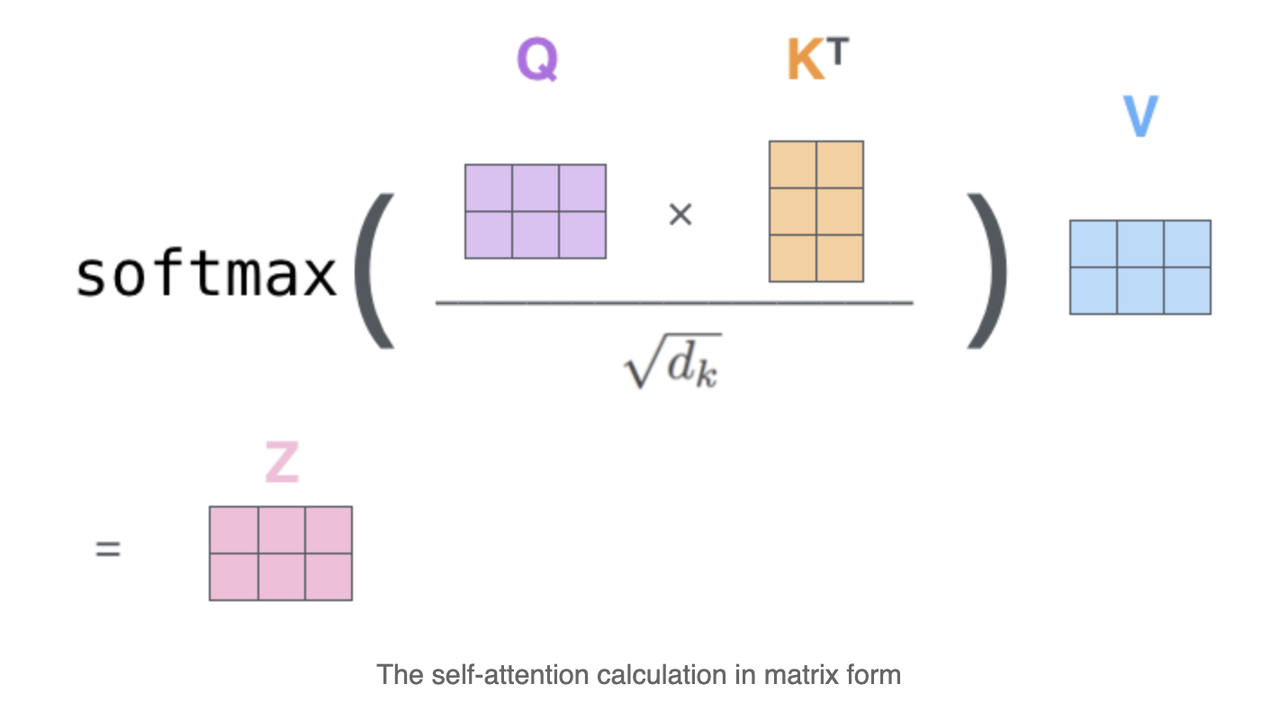
[img source](https://www.linkedin.com/pulse/self-attention-why-we-divide-score-square-root-key-vector-yadav-)

### Key Concepts

- **Causal Self-Attention:** This mechanism ensures that each token can only attend to itself and previous tokens in the sequence. Future tokens are masked out, preventing the model from gaining information about upcoming inputs.

### Implementation Steps

1. **Attention Score Calculation**
   - Compute the attention scores for the input tokens using a dot product between the query and key representations. This gives you a matrix of scores that indicates how much focus each token should have on others.

2. **Masking Future Tokens**
   - Apply a masking technique to zero out the scores for future tokens. This is typically done by setting the upper triangular part of the attention score matrix to negative infinity (or a very large negative value). This ensures that when you apply the softmax function, those positions will result in zero probability.

3. **Softmax Normalization**
   - Use the softmax function to convert the masked attention scores into attention weights. These weights will determine how much each token influences the final representation.

4. **Weighted Sum of Values**
   - Compute the final output by taking a weighted sum of the value vectors, using the attention weights calculated in the previous step. This results in a new representation for each token that incorporates information from the tokens that precede it.

### Example Illustration

- **Input Tokens:** `["I", "am", "learning", "GPT"]`
- **Causal Masking:**
  - For the token "learning", the attention matrix might look like this:
    ```
    I   am  learning  GPT
    ------------------------
    1   0   0         0   (I can attend to I)
    1   1   0         0   (am can attend to I, am)
    1   1   1         0   (learning can attend to I, am, learning)
    1   1   1         1   (GPT cannot attend to I, am, learning)
    ```
- This ensures that each token only attends to itself and the tokens before it.

### Implementation Note

As you implement causal self-attention, ensure that:
- The masking is correctly applied to prevent information leakage from future tokens.
- You test your implementation with various input sequences to verify that the outputs are as expected.

### Next Steps

After implementing the causal self-attention mechanism, you will integrate it with the other components of the GPT decoder. This will enable your model to process sequences effectively and generate coherent text.



The following figure will gives a very good visualization of how mask is applied for causal language modeling


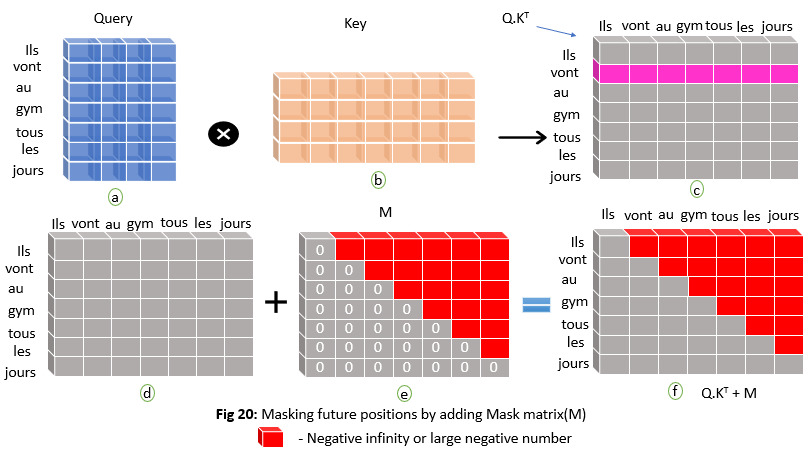

[img source](https://raviteja-ganta.github.io/attention-is-all-you-need-transformers)

In [189]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(
            n_embd, head_size, bias=False
        )  # Linear layer for key transformation
        self.query = nn.Linear(
            n_embd, head_size, bias=False
        )  # Linear layer for query transformation
        self.value = nn.Linear(
            n_embd, head_size, bias=False
        )  # Linear layer for value transformation
        self.register_buffer(
            "tril", torch.tril(torch.ones(block_size, block_size))
        )  # Lower triangular matrix for masking
        self.dropout = nn.Dropout(dropout)  # Dropout layer for regularization

    def forward(self, x):
        """
        Forward pass for the attention head.

        Parameters:
        - x: Tensor of shape (B, T, C) where B is the batch size, T is the sequence length,
             and C is the embedding dimension.

        Returns:
        - out: Tensor of shape (B, T, head_size) representing the output of the attention head.
        """

        B, T, C = x.shape

        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        wei = q @ k.transpose(-2, -1) * C**-0.5

        wei = wei.masked_fill(self.tril == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v

        return out

## Implementing Multi-Head Self-Attention

In this section, you will implement multi-head self-attention, an extension of the self-attention mechanism that allows the model to focus on different parts of the input sequence simultaneously. By using multiple attention heads, the model can capture a richer set of relationships among tokens.


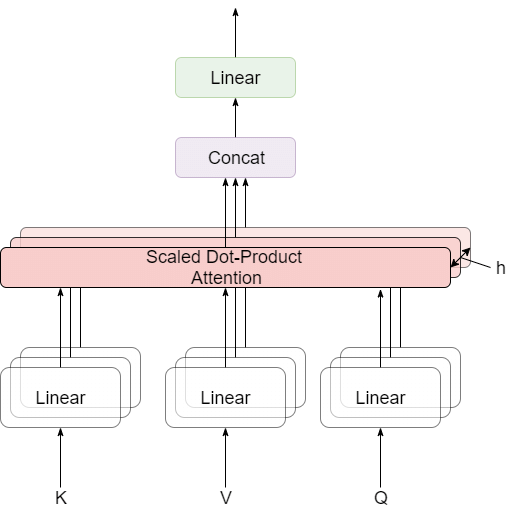

[img source](https://www.researchgate.net/publication/339350384/figure/fig5/AS:860134590935042@1582083475953/The-concept-of-Multi-head-Self-attention.ppm)

### Key Concepts

- **Multi-Head Self-Attention:** This mechanism runs multiple self-attention operations in parallel, each with different learnable parameters. The outputs of these attention heads are then concatenated and linearly transformed to produce the final output. This allows the model to learn different representations and relationships for the same input.

### Implementation Steps

1. **Linear Projections**
   - For each attention head, project the input embeddings into three different spaces: **Queries (Q)**, **Keys (K)**, and **Values (V)**. This is typically done using three separate linear layers, one for each projection.
   - If you have \( h \) heads and an embedding dimension of \( d \), each head will work with \( d/h \) dimensions.

2. **Compute Attention for Each Head**
   - For each head, compute the scaled dot-product attention using the projected queries, keys, and values. This involves:
     - Calculating the attention scores.
     - Applying causal masking to ensure future tokens are not considered.
     - Normalizing the scores with softmax to get attention weights.
     - Obtaining the output for each head by applying the attention weights to the corresponding values.

3. **Concatenate Head Outputs**
   - After computing the outputs for all attention heads, concatenate these outputs along the feature dimension. This results in a combined representation that incorporates information from all heads.

4. **Final Linear Transformation**
   - Apply a linear transformation to the concatenated outputs to map them back to the original embedding dimension. This step helps in maintaining a consistent size throughout the layers.

### Example Illustration

- **Input Tokens:** `["I", "am", "learning", "GPT"]`
- **Head Processing:**
  - Assume you have 2 attention heads. Each head would independently process the input, focusing on different aspects of the sequence.
  - For example, Head 1 might learn to focus on syntactic relationships, while Head 2 captures semantic meanings.

### Benefits of Multi-Head Attention

- **Diversity of Representations:** By using multiple heads, the model can learn various representations of the input data, capturing complex patterns and relationships.
- **Improved Performance:** Multi-head attention often leads to improved performance in language tasks, as it allows the model to aggregate information from different parts of the input more effectively.

### Implementation Note

When implementing multi-head self-attention, pay attention to:
- The dimension of each head and ensure that the final output shape matches the expected embedding size.
- Testing with various input sequences to confirm that the model captures the intended relationships.

### Next Steps

After implementing multi-head self-attention, you will integrate it with the other components of the GPT decoder. This will enhance the model's ability to process sequences and generate contextually relevant output.


In [190]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])  # Create a list of attention heads
        self.proj = nn.Linear(n_embd, n_embd)  # Linear layer to project the concatenated output of heads
        self.dropout = nn.Dropout(dropout)  # Dropout layer for regularization

    def forward(self, x):
        """
        Forward pass for multi-head attention.

        Parameters:
        - x: Tensor of shape (B, T, C) where B is the batch size, T is the sequence length,
             and C is the embedding dimension.

        Returns:
        - out: Tensor of shape (B, T, C) representing the output of the multi-head attention.
        """
        out = torch.cat([h(x) for h in self.heads], dim=-1)

        out = self.proj(out)
        
        out = self.dropout(out)

        return out

In [191]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        """
        Forward pass for the feed-forward network.

        Parameters:
        - x: Tensor of shape (B, T, C) where B is the batch size, T is the sequence length,
             and C is the embedding dimension.

        Returns:
        - out: Tensor of the same shape as x, representing the output of the feed-forward network.
        """

        out = self.net(x)

        return out

## Transformer Block Implementation

In this section, you will implement a transformer block, which consists of multi-head self-attention and a feed-forward network. This block forms the foundation of the GPT architecture and processes the input sequences by capturing dependencies and enhancing the representations.

### Class: `Block`

- **Purpose:** The `Block` class is responsible for applying the multi-head self-attention mechanism and the feed-forward network to the input embeddings while incorporating layer normalization and residual connections.

### Key Components

1. **Multi-Head Self-Attention (`sa`):**
   - Utilizes the `MultiHeadAttention` class to implement the self-attention mechanism, allowing the model to focus on different parts of the input sequence simultaneously.

2. **Feed-Forward Network (`ffwd`):**
   - Implements the `FeedForward` class to apply a series of linear transformations and non-linear activations, enhancing the model's expressiveness.

3. **Layer Normalization (`ln1` and `ln2`):**
   - Applies layer normalization before both the self-attention and feed-forward layers to stabilize training and improve convergence.

### Implementation Steps

- In the `__init__` method:
  - Define the multi-head self-attention and feed-forward layers.
  - Initialize the layer normalization components.

- In the `forward` method:
  - Apply layer normalization to the input before the self-attention layer.
  - Implement a residual connection by adding the output of the self-attention layer to the original input.
  - Apply layer normalization before the feed-forward layer.
  - Implement another residual connection by adding the output of the feed-forward network to the original input.

This structure allows the model to process inputs effectively, leveraging the strengths of both self-attention and feed-forward networks.


In [192]:
class Block(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()

        head_size = n_embd // n_heads

        self.ln1 = nn.LayerNorm(n_embd)
        self.sa = MultiHeadAttention(n_heads, head_size)

        self.ln2 = nn.LayerNorm(n_embd)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        """
        Forward pass for the transformer block.

        Parameters:
        - x: Tensor of shape (B, T, C) where B is the batch size, T is the sequence length,
             and C is the embedding dimension.

        Returns:
        - x: Tensor of the same shape as the input, after passing through the self-attention
             and feed-forward layers with residual connections.
        """

        x = x + self.sa(self.ln1(x))

        x = x + self.ffwd(self.ln2(x))

        return x

## Language Model Implementation

In this section, we will implement a language model based on the transformer architecture. This model is designed to process sequences of tokens and generate predictions for the next token in the sequence, leveraging both token and positional embeddings, multiple transformer blocks, and a final linear layer.

### Class: `LanguageModel`

- **Purpose:** The `LanguageModel` class encapsulates the entire architecture of the transformer model, handling the embedding of tokens, the application of transformer blocks, and the generation of output logits for predicting the next token.

### Key Components

1. **Token Embedding Table (`token_embedding_table`):**
   - Uses `nn.Embedding` to convert input token indices into dense vector representations of size `n_embd`.

2. **Position Embedding Table (`position_embedding_table`):**
   - Another `nn.Embedding` that provides positional information for each token in the sequence, allowing the model to maintain the order of tokens.

3. **Transformer Blocks (`blocks`):**
   - A sequence of transformer blocks defined by the `Block` class. Each block applies multi-head self-attention and feed-forward networks, allowing the model to learn complex relationships between tokens.

4. **Layer Normalization (`ln_f`):**
   - Applies layer normalization to the output of the transformer blocks to stabilize and enhance the model’s performance.

5. **Output Linear Layer (`lm_head`):**
   - A linear layer that produces output logits corresponding to the vocabulary size, enabling the model to predict the next token in the sequence.

### Forward Pass

- The `forward` method processes the input indices and optional target indices:
  1. Extracts the batch size \( B \) and sequence length \( T \) from the input.
  2. Computes token embeddings and positional embeddings, adding them together to form the input representation.
  3. Passes the combined embeddings through the transformer blocks.
  4. Applies layer normalization to the output.
  5. Computes the output logits using the linear layer.

- If target indices are provided, it calculates the cross-entropy loss for training.

### Generation Method

- The `generate` method allows the model to produce new tokens:
  1. For a specified number of new tokens, it maintains the most recent context from the input.
  2. Computes logits for the next token based on the context.
  3. Uses the softmax function to convert logits to probabilities.
  4. Samples the next token using multinomial sampling based on the computed probabilities.
  5. Concatenates the newly generated token to the input sequence.

### Model Initialization

- The `LanguageModel` is instantiated and moved to the specified device (CPU or GPU) for training or inference.



In [193]:
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_emebdding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(
            *[Block(n_embd=n_embd, n_heads=n_head) for _ in range(n_layer)]
        )
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)  # produce output logits

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_embd = self.token_emebdding_table(idx)
        pos_embd = self.position_embedding_table(torch.arange(T, device=device))

        x = tok_embd + pos_embd
        x = self.blocks(x)
        x = self.ln_f(x)

        logits = self.lm_head(x)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape

            logits = logits.view(B * T, C)
            targets = targets.view(B * T)

            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        """
        Generate new tokens based on the input index tensor.

        Parameters:
        - idx: Tensor of shape (B, T) where B is the batch size and T is the sequence length.
        - max_new_tokens: Maximum number of new tokens to generate.

        Returns:
        - idx: Tensor containing the original indices and the newly generated tokens.
        """

        B, T = idx.shape

        if T < block_size:
            padding = torch.zeros((B, block_size - T), dtype=torch.long, device=device)
            idx = torch.cat([padding, idx], dim=1)

        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]

            logits, _ = self(idx_cond)

            logits = logits[:, -1, :]

            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)

            idx = torch.cat((idx, idx_next), dim=1)

        idx = idx[:, -(T + max_new_tokens) :]

        return idx


model = LanguageModel()

m = model.to(device=device)

## Training and Evaluating the Language Model

This section of the code handles the training and evaluation of the `LanguageModel`. It defines a function to estimate the loss on both training and validation datasets and executes the training loop with periodic evaluation.

### Function: `estimate_loss`

- **Purpose:** Estimates the average loss on the training and validation splits without computing gradients (using `torch.no_grad()` to save memory and computation).
- **Parameters:**
  - None directly, but it evaluates both 'train' and 'val' splits.
- **Returns:**
  - A dictionary containing the mean losses for both splits.

#### Key Steps:
1. **Set Model to Evaluation Mode:**
   - Calls `model.eval()` to deactivate dropout and other training-specific layers.
  
2. **Loss Calculation:**
   - Initializes a tensor to store losses.
   - Iterates over `eval_iters`, obtaining batches of data using `get_batch()`.
   - Computes the model's output and loss, storing the loss values.
   - Averages the losses for the current split.

3. **Reset Model to Training Mode:**
   - Calls `model.train()` to reactivate training-specific behaviors.

### Optimizer Initialization

- **Optimizer:**
  - Uses AdamW optimizer from PyTorch to optimize the model's parameters with weight decay.
  - Sets the learning rate to `learning_rate`.

### Training Loop

- **Iteration:**
  - Loops through a defined number of iterations (`max_iter`).
  
- **Periodic Evaluation:**
  - Every `eval_interval` iterations or at the last iteration, it estimates the loss using `estimate_loss()` and prints the average training and validation losses.

- **Batch Sampling and Loss Evaluation:**
  - Samples a batch of training data using `get_batch('train')`.
  - Computes the logits and loss from the model.
  - Resets gradients with `optimizer.zero_grad(set_to_none=True)`.
  - Performs backpropagation with `loss.backward()`.
  - Updates the model parameters with `optimizer.step()`.

### Generating New Tokens

- **Context Initialization:**
  - Initializes a context tensor of zeros, which acts as the starting input for the model.

- **Token Generation:**
  - Calls the `generate` method of the model to produce `max_new_tokens`.
  - Decodes the generated token indices into human-readable text using `decode()`.

### Example of Generated Text

- The model generates up to 500 new tokens based on the initial context, demonstrating its capability to create coherent text based on learned patterns.



In [194]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()

    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)

        for k in range(eval_iters):
            X, Y = get_batch(data, split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()

        out[split] = losses.mean()

    model.train()

    return out


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


def train():
    for iter in range(max_iter):
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iter - 1:
            losses = estimate_loss()
            print(
                f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
            )

        # sample a batch of data
        xb, yb = get_batch(data, "train")

        # evaluate the loss
        logits, loss = model(xb, yb)

        optimizer.zero_grad(set_to_none=True)

        loss.backward()

        optimizer.step()


train()


context = torch.zeros((1, 1), dtype=torch.long, device=device)

print(decode(model.generate(context, max_new_tokens=500)[0].tolist())[1:])

torch.Size([16, 32, 8])
torch.Size([1, 32, 4, 2])
torch.Size([16, 32, 8])
torch.Size([1, 32, 4, 2])


RuntimeError: The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 3

# Part 2: Implementing a Llama Style Decoder

In this section, we will modify the GPT decoder that we have previously implemented to align with the Llama architecture. The following modifications will be made to enhance the model's performance and efficiency:

## Modifications

1. **Implementing Byte Pair Encoding (BPE):**
   - We will replace the naive character tokenizer with a more sophisticated Byte Pair Encoder. This change will allow us to manage vocabulary size effectively while improving the model's ability to handle out-of-vocabulary words by using subword units.

2. **Replacing Layer Norms with RMSNorm:**
   - All occurrences of layer normalization in the original model will be replaced with RMS normalization (RMSNorm). This adjustment can improve training stability and reduce training time by modifying how normalization is applied across the embeddings.

3. **Replacing Positional Encoding with RoPE (Rotary Positional Encoding):**
   - Traditional positional encoding will be replaced with Rotary Positional Encoding (RoPE). RoPE allows for better representation of the order of tokens in a sequence, particularly for long sequences, which can enhance the model's performance on tasks requiring context awareness.

4. **Updating the FeedForward Block to Use SwiGLU:**
   - The FeedForward block will be updated to utilize the SwiGLU (Swish-Gated Linear Unit) activation function. SwiGLU combines the Swish activation with a gating mechanism, potentially providing better performance than standard activation functions.

Here is the visualization of the Llama decoder.

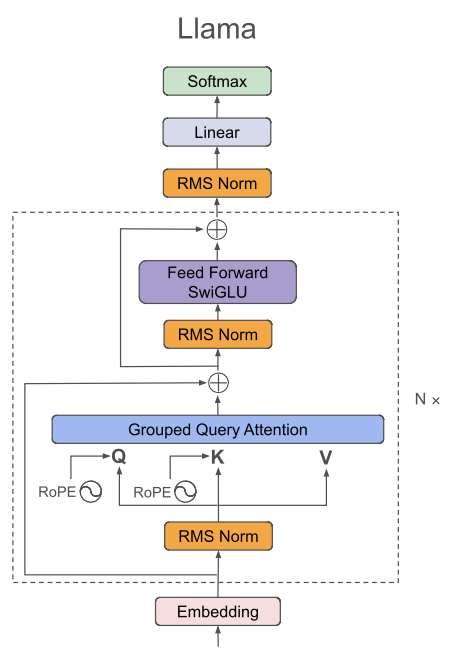


Note:
You are not required to implement grouped query attention, but if you want do give it shot

## Byte Pair Encoding (BPE) Implementation

In this section, we implement the Byte Pair Encoding (BPE) algorithm, a popular subword tokenization method used to efficiently encode text for various natural language processing tasks. BPE helps to manage the trade-off between vocabulary size and the ability to handle out-of-vocabulary words by breaking down words into subword units.

### Class: `BPE`

- **Purpose:** The `BPE` class is designed to build a vocabulary of subword tokens based on the BPE algorithm, which merges the most frequently occurring pairs of characters or subwords in the training text until a specified vocabulary size is reached.

### Key Components

1. **Initialization (`__init__`):**
   - **Parameters:**
     - `vocab_size`: The desired size of the vocabulary.
   - Initializes empty dictionaries for `vocab` (mapping of subword tokens to indices) and `inverse_vocab` (mapping of indices back to subword tokens).

2. **Fitting the Model (`fit`):**
   - **Parameters:**
     - `text`: Input text to build the vocabulary from.
   - Initializes the vocabulary with characters and counts word occurrences.
   - Iteratively merges the most frequent pairs of tokens until the vocabulary reaches the specified size.

3. **Encoding Text (`encode`):**
   - **Parameters:**
     - `text`: The input text to encode.
   - Converts words into their respective subword token indices based on the learned vocabulary.

4. **Decoding Tokens (`decode`):**
   - **Parameters:**
     - `encoded`: A list of token indices to decode.
   - Transforms the encoded indices back into a human-readable string.

### How BPE Works

BPE operates through a series of steps that involve counting and merging pairs of characters in the dataset. Here’s a step-by-step explanation:

1. **Initialization:**
   - Start with a vocabulary consisting of all unique characters in the dataset.

2. **Counting Pairs:**
   - Count the frequency of all adjacent pairs of tokens (initially characters) in the training text.

3. **Merging Pairs:**
   - Identify the most frequent pair and merge it into a new token. For example, if "l" and "o" appear together frequently, they might be merged into "lo".

4. **Updating the Vocabulary:**
   - Update the vocabulary to include the newly formed token and adjust the word counts accordingly.

5. **Repeat:**
   - Repeat the counting and merging process until the desired vocabulary size is reached.

### Example of BPE

Let’s consider a simple example with the following text:


#### Step-by-Step Process:

1. **Initialization:**
   - Initial tokens: `l`, `o`, `w`, `l`, `o`, `w`, `e`, `r`, `n`, `e`, `w`, `e`, `s`, `t`.

2. **Counting Pairs:**
   - Pairs and their frequencies:
     - (`l`, `o`): 2
     - (`o`, `w`): 3
     - (`w`, `e`): 1
     - (`e`, `r`): 1
     - (`n`, `e`): 1
     - (`w`, `e`): 1
     - (`e`, `s`): 1
     - (`s`, `t`): 1

3. **Merging Pairs:**
   - The most frequent pair is (`o`, `w`), which will be merged into a new token `ow`.

4. **Updated Text:**
   - After merging, the words transform as follows:
     - `low` becomes `l` + `ow`
     - `lower` becomes `l` + `ow` + `e` + `r`
     - `newest` remains unchanged since it doesn't contain `o` and `w`.

5. **Next Iterations:**
   - This process repeats, merging the next most frequent pairs until the vocabulary limit is reached.

In [57]:
class BPE:
    def __init__(self, vocab_size):
        """
        Initializes the BPE tokenizer.

        Parameters:
        - vocab_size (int): The maximum size of the vocabulary.
        """

        self.vocab_size = vocab_size

        self.merges = {}
        self.decoder = {i: bytes([i]) for i in range(256)}

    def fit(self, text):
        """
        Fits the BPE model to the provided text.

        Parameters:
        - text (str): The input text used to build the vocabulary and determine the most common byte pairs.

        The method should:
        1. Tokenize the input text into individual characters or symbols.
        2. Count the frequency of each symbol and pair of symbols.
        3. Merge the most frequent pairs iteratively until the vocabulary size is reached.
        4. Store the resulting vocabulary for encoding.


        Returns:
        - None: This method should modify the internal state of the BPE instance.
        """

        if self.vocab_size <= 256:
            raise ValueError("vocab_size must be greater than 256")

        tokens = text.encode("utf-8")
        tokens = list(map(int, tokens))
        tokens = list(tokens)

        print("Tokens before merging: ", len(tokens))

        for merge_num in range(self.vocab_size - 256):
            # Count pair frequencies
            counts = {}

            for pair in zip(tokens, tokens[1:]):
                counts[pair] = counts.get(pair, 0) + 1

            # Find most common pair
            pair = max(counts, key=counts.get)
            new_token = 256 + merge_num

            self.merges[pair] = new_token
            self.decoder[new_token] = self.decoder[pair[0]] + self.decoder[pair[1]]

            new_tokens = []
            i = 0

            # Replace the pair with new token in our text
            while i < len(tokens):
                if i < len(tokens) - 1 and (tokens[i], tokens[i + 1]) == pair:
                    new_tokens.append(new_token)
                    i += 2
                else:
                    new_tokens.append(tokens[i])
                    i += 1

            tokens = new_tokens

        print("Tokens after merging:", len(tokens))

    def encode(self, text):
        """
        Encodes the input text into a sequence of BPE tokens.

        Parameters:
        - text (str): The input text to be encoded.

        Returns:
        - List of tokens: A list representing the text in terms of the BPE vocabulary.

        The method should:
        1. Tokenize the input text into individual characters or symbols.
        2. Replace the characters/symbols with their corresponding BPE tokens from the vocabulary.
        """
        tokens = list(map(int, text.encode("utf-8")))

        while True:
            possible_merges = {}

            for i in range(len(tokens) - 1):
                pair = (tokens[i], tokens[i + 1])

                if pair in self.merges:
                    possible_merges[i] = self.merges[pair]

            if not possible_merges:
                break

            new_tokens = []

            i = 0

            while i < len(tokens):
                if i in possible_merges:
                    new_tokens.append(possible_merges[i])
                    i += 2
                else:
                    new_tokens.append(tokens[i])
                    i += 1

            tokens = new_tokens

        return tokens

    def decode(self, encoded):
        """
        Decodes a sequence of BPE tokens back into the original text.

        Parameters:
        - encoded (List): A list of BPE tokens to be decoded.

        Returns:
        - str: The original text corresponding to the encoded tokens.

        The method should:
        1. Iterate through the list of BPE tokens.
        2. Replace each token with its corresponding character/symbol.
        3. Reconstruct the original text from the tokens.
        """
        tokens = b"".join(self.decoder[idx] for idx in encoded)

        return tokens.decode("utf-8", errors="replace")


bpe = BPE(vocab_size=5000)

text = open("input.txt", "r").read()

bpe.fit(text)

data = torch.tensor(bpe.encode(text), dtype=torch.long)

print("\n Encoder-Decoder: ", bpe.decode(bpe.encode(text)) == text)

n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]


Tokens before merging:  1115394
Tokens after merging: 280573

 Encoder-Decoder:  True


In [225]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    
    max_idx = len(data) - block_size - 1

    ix = torch.randint(max_idx, (batch_size,))

    x = torch.stack([data[x:x+block_size] for x in ix])

    y = torch.stack([data[x+1:x+block_size+1] for x in ix])

    return x.to(device), y.to(device)

## Modify the GPT Head to Use RoPE

In this section, we will focus on enhancing the self-attention mechanism of our GPT model by integrating Rotary Positional Encoding (RoPE) into the `Head` class. RoPE is an advanced technique that helps the model better capture the positional information of tokens within a sequence, allowing it to understand the order and relationships more effectively.


You can implement RoPE using the following formula

$$
R_{\Theta,m}^d \mathbf{x} =
\begin{pmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
\vdots \\
x_{d-1} \\
x_d
\end{pmatrix}
\otimes
\begin{pmatrix}
\cos m \theta_1 \\
\cos m \theta_1 \\
\cos m \theta_2 \\
\cos m \theta_2 \\
\vdots \\
\cos m \theta_{d/2} \\
\cos m \theta_{d/2}
\end{pmatrix}
+
\begin{pmatrix}
-x_2 \\
x_1 \\
-x_4 \\
x_3 \\
\vdots \\
-x_d \\
x_{d-1}
\end{pmatrix}
\otimes
\begin{pmatrix}
\sin m \theta_1 \\
\sin m \theta_1 \\
\sin m \theta_2 \\
\sin m \theta_2 \\
\vdots \\
\sin m \theta_{d/2} \\
\sin m \theta_{d/2}
\end{pmatrix}
$$

where theta is defined as

$$
\theta_i = 10000^{-\frac{2(i - 1)}{d}}
$$


### Overview of RoPE Integration

The goal of this modification is to adjust how the query and key vectors are generated and utilized within the self-attention mechanism. Here's how we will approach this:

1. **Initialization of RoPE Parameters:**
   - First, we need to compute the sine and cosine values that will be used for the RoPE transformation. This involves calculating the inverse frequencies based on the embedding dimension size and the maximum sequence length (block size).
   - These values will be stored as buffers within the model, allowing us to access them efficiently during the forward pass.

2. **Applying RoPE to Query and Key Vectors:**
   - Once we have the query and key vectors computed from the input, we will apply the RoPE transformation. This requires splitting the query and key vectors into two parts, using the sine and cosine values to perform a rotation.
   - This rotation enhances the representation of positional information, as it modifies the query and key vectors based on their relative positions in the sequence.

3. **Forward Pass Implementation:**
   - During the forward pass of the attention head, after obtaining the query, key, and value vectors, we will invoke the RoPE application function before proceeding with the attention calculations.
   - The standard self-attention mechanism will then be executed, incorporating the transformed query and key vectors. The masking operation will also remain to ensure causal attention.

### Benefits of Using RoPE

Integrating RoPE into the attention mechanism provides several advantages:
- **Improved Contextual Understanding:** By rotating the query and key vectors based on their positions, the model can better understand how tokens relate to one another within the context of their sequences.
- **Enhanced Efficiency:** RoPE allows for efficient encoding of positional information, which can be particularly beneficial for longer sequences where traditional positional encodings might struggle.

### Example Walkthrough

To clarify our implementation approach, consider the following steps that will be taken within the `Head` class:

1. **Compute Inverse Frequencies:**
   - We will initialize the inverse frequencies that are necessary for the angle calculations used in RoPE.

2. **Store Cosine and Sine Buffers:**
   - We will create buffers to store the computed cosine and sine values for the angles, which will be used to apply the rotation to the query and key vectors.

3. **Implement the `apply_rope` Method:**
   - This method will handle the transformation of the query and key vectors. It will perform the rotation and prepare the vectors for the subsequent attention computation.

4. **Modify the Forward Method:**
   - In the forward pass, we will incorporate our RoPE application step before the attention calculation, ensuring that the self-attention mechanism leverages the enhanced positional information.

By following this structured approach, we will successfully modify the GPT head to incorporate RoPE, enhancing our model's ability to process sequential data more effectively.

This process not only aligns with the architecture of the Llama-style decoder but also serves to improve the overall performance of our language model.


Paper
[RoFormer: Enhanced Transformer with Rotary Position Embedding](https://arxiv.org/pdf/2104.09864)


In [219]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

        inv_freq = 1.0 / (10000 ** (torch.arange(0, head_size, 2).float() / head_size))
        pos = torch.arange(0, block_size).float()
        angles = torch.outer(pos, inv_freq)  # (block_size, head_size // 2) frequencies

        cos = torch.cos(angles).view(1, block_size, 1, head_size // 2)
        cos = cos.repeat(1, 1, 2, 1).view(
            1, block_size, head_size
        )  # (1, block_size, head_size)

        sin = torch.sin(angles).view(1, block_size, 1, head_size // 2)
        sin = sin.repeat(1, 1, 2, 1).view(
            1, block_size, head_size
        )  # (1, block_size, head_size)

        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)

    def apply_rope(self, q, k, seq_len):
        """
        Applies Rotational Positional Encoding (RoPE) to the query and key tensors.

        Parameters:
        - q (Tensor): The query tensor of shape (B, T, head_size).
        - k (Tensor): The key tensor of shape (B, T, head_size).
        - seq_len (int): The length of the sequence.

        Returns:
        - q_rot (Tensor): Rotated query tensor after applying RoPE.
        - k_rot (Tensor): Rotated key tensor after applying RoPE.
        """

        cos = self.cos[:, :seq_len, :]
        sin = self.sin[:, :seq_len, :]

        q_even = q[..., 0::2]
        q_odd = q[..., 1::2]
        k_even = k[..., 0::2]
        k_odd = k[..., 1::2]

        q_mixed = torch.empty_like(q)
        k_mixed = torch.empty_like(k)

        q_mixed[..., 0::2] = -q_odd
        q_mixed[..., 1::2] = q_even
        k_mixed[..., 0::2] = -k_odd
        k_mixed[..., 1::2] = k_even

        q_rot = q * cos + q_mixed * sin
        k_rot = k * cos + k_mixed * sin

        return q_rot, k_rot

    def forward(self, x):
        B, T, C = x.shape

        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        q, k = self.apply_rope(q, k, T)

        wei = q @ k.transpose(-2, -1) * C**-0.5

        wei = wei.masked_fill(self.tril == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v

        return out


head = Head(head_size=n_embd // n_head)

# Implementing SwiGLU
In this section, we will modify the feed-forward network (FFN) to implement the SwiGLU activation function. SwiGLU combines the Swish activation with a gated linear unit, defined as:

$$
\text{FFN}_{\text{SwiGLU}}(x) = \left(\text{Swish}(xW) \odot (xV)\right) W_2
$$

### Steps to Implement SwiGLU
1. **Weight Initialization:**
   - Initialize weight matrices $W$, $V$, and $W_2$ in the feed-forward network constructor.
2. **Forward Pass:**
   - Compute $z = xW$ and apply Swish activation:
   $$
   \text{Swish}(z) = z \cdot \sigma(z)
   $$
   - Compute $g = xV$ for the gating mechanism.
   - Perform element-wise multiplication of the Swish output and the gating output:
   $$
   \text{output} = \text{Swish}(z) \odot g
   $$
   - Finally, multiply by $W_2$ to get the final output:
   $$
   \text{output} = \text{output} W_2
   $$

### Benefits of SwiGLU
- **Enhanced Expressiveness:** The gating mechanism captures complex interactions in the input data.
- **Mitigated Gradient Vanishing:** The Swish activation helps alleviate the vanishing gradient problem.

Paper
[GLU Variants Improve Transformer](https://arxiv.org/pdf/2002.05202v1)

In [220]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        """
        Initializes the FeedForward neural network.

        Parameters:
        - n_embd (int): The dimensionality of the input and output embeddings.

        The constructor sets up the following:
        - Two linear layers for transformation.
        - An additional linear layer for residual connections.
        """
        super().__init__()

        self.w1 = nn.Linear(n_embd, 4 * n_embd)
        self.w2 = nn.Linear(4 * n_embd, n_embd)
        self.w3 = nn.Linear(n_embd, n_embd * 4)

    def forward(self, x):
        """
        Forward pass for the FeedForward network.

        Parameters:
        - x (Tensor): Input tensor of shape (B, T, n_embd), where B is batch size, T is sequence length.

        Returns:
        - Tensor: Output tensor of the same shape as input after applying the feedforward operations.

        The method performs the following operations:
        1. Applies the first linear transformation to the input tensor.
        2. Applies the Silu activation function (Sigmoid Linear Unit).
        3. Multiplies the result by the output of the third linear transformation.
        4. Applies the second linear transformation to the resulting tensor.
        """
        
        out = F.silu(self.w1(x)) * self.w3(x)
        
        out = self.w2(out)

        return out

# Completing the GPT Model

## Overview
For the most part, the GPT model will remain the same. We'll now be incorporating the updates to our language model. The final model should have the following updates:

- New head
- Rotary Positional Encoding (RoPE)
- Byte Pair Encoding (BPE)
- RMSProp optimizer


In [221]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()

        self.heads = nn.ModuleList(
            [Head(head_size) for _ in range(num_heads)]
        )  # Create a list of attention heads
        self.proj = nn.Linear(
            n_embd, n_embd
        )  # Linear layer to project the concatenated output of heads
        self.dropout = nn.Dropout(dropout)  # Dropout layer for regularization

    def forward(self, x):
        """
        Forward pass for multi-head attention.

        Parameters:
        - x: Tensor of shape (B, T, C) where B is the batch size, T is the sequence length,
             and C is the embedding dimension.

        Returns:
        - out: Tensor of shape (B, T, C) representing the output of the multi-head attention.
        """
        out = torch.cat([h(x) for h in self.heads], dim=-1)

        out = self.proj(out)

        out = self.dropout(out)

        return out


class Block(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()

        head_size = n_embd // n_heads

        self.ln1 = nn.RMSNorm(n_embd)
        self.sa = MultiHeadAttention(n_heads, head_size)

        self.ln2 = nn.RMSNorm(n_embd)
        self.ffwd = FeedForward(n_embd)

    def forward(self, x):
        """
        Forward pass for the transformer block.

        Parameters:
        - x: Tensor of shape (B, T, C) where B is the batch size, T is the sequence length,
             and C is the embedding dimension.

        Returns:
        - x: Tensor of the same shape as the input, after passing through the self-attention
             and feed-forward layers with residual connections.
        """

        x = x + self.sa(self.ln1(x))

        x = x + self.ffwd(self.ln2(x))

        return x


class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_emebdding_table = nn.Embedding(vocab_size, n_embd)
        # self.position_embedding_table = nn.Embedding(
        #     block_size, n_embd
        # )

        self.blocks = nn.Sequential(
            *[Block(n_embd=n_embd, n_heads=n_head) for _ in range(n_layer)]
        )

        self.ln_f = nn.RMSNorm(n_embd)

        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_embd = self.token_emebdding_table(idx)
        # pos_embd = self.position_embedding_table(
        #     torch.arange(T, device=device)
        # )

        x = tok_embd  # + pos_embd
        x = self.blocks(x)
        x = self.ln_f(x)

        logits = self.lm_head(x)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape

            logits = logits.view(B * T, C)
            targets = targets.view(B * T)

            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        """
        Generate new tokens based on the input index tensor.

        Parameters:
        - idx: Tensor of shape (B, T) where B is the batch size and T is the sequence length.
        - max_new_tokens: Maximum number of new tokens to generate.

        Returns:
        - idx: Tensor containing the original indices and the newly generated tokens.
        """

        B, T = idx.shape

        if T < block_size:
            padding = torch.zeros((B, block_size - T), dtype=torch.long, device=device)
            idx = torch.cat([padding, idx], dim=1)

        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]

            logits, _ = self(idx_cond)

            logits = logits[:, -1, :]

            probs = F.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)

            idx = torch.cat((idx, idx_next), dim=1)

        idx = idx[:, -(T + max_new_tokens) :]

        return idx


model = LanguageModel()
m = model.to(device=device)


## Training Loop

In [222]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


def train():
    for iter in range(max_iter):
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iter - 1:
            losses = estimate_loss()
            print(
                f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
            )

        # sample a batch of data
        xb, yb = get_batch("train")

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


train()

step 0: train loss 4.3592, val loss 4.3536
step 100: train loss 2.4936, val loss 2.5048
step 200: train loss 2.3586, val loss 2.3728
step 300: train loss 2.2478, val loss 2.2611
step 400: train loss 2.1350, val loss 2.1737
step 500: train loss 2.0628, val loss 2.1001
step 600: train loss 1.9965, val loss 2.0693
step 700: train loss 1.9332, val loss 2.0204
step 800: train loss 1.9045, val loss 1.9944
step 900: train loss 1.8653, val loss 1.9728
step 1000: train loss 1.8377, val loss 1.9462
step 1100: train loss 1.8069, val loss 1.9369
step 1200: train loss 1.7946, val loss 1.9181
step 1300: train loss 1.7736, val loss 1.8971
step 1400: train loss 1.7663, val loss 1.9080
step 1500: train loss 1.7394, val loss 1.8966
step 1600: train loss 1.7348, val loss 1.8769
step 1700: train loss 1.7188, val loss 1.8575
step 1800: train loss 1.6958, val loss 1.8785
step 1900: train loss 1.6879, val loss 1.8547
step 2000: train loss 1.6921, val loss 1.8585
step 2100: train loss 1.6863, val loss 1.8439


In [223]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)

print(decode(model.generate(context, max_new_tokens=500)[0].tolist())[1:])

ClDUIUS:
A firstreman, I known but myself, may my talk robed all would.

HENRY VOMPEDWARD:
Is aplatine would then 's oll to theurly,
Menihy, with which a son. To ladsblid sleed.
Shall Provost: so he alreephieh 'twench an provern;
How out true, more all you, you and dal, and thle turns.

BENKEgenal of service weld, whithen hare as hear of out,
And se, almongenst for hontenmil encannest.
Good Besent sinche. E What
Well him myself you, kill how w note king my shaJt;
And I dought, many desise true;'
